In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
plt.rcParams.update({'font.size': 15})

Load nc file:

In [2]:
ds = xr.open_dataset('./nc/grandmesa.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (line: 2030, pixel: 1354, time: 90)
Coordinates:
    longitude  (time, line, pixel) float32 ...
    latitude   (time, line, pixel) float32 ...
  * time       (time) datetime64[ns] 2017-02-10T05:45:00 ... 2017-03-01T19:55:00
Dimensions without coordinates: line, pixel
Data variables:
    lst        (time, line, pixel) float64 ...
    viewangle  (time, line, pixel) float64 ...

---
#### Analysis:
Plot and save each MODIS timestep figure

In [13]:
#for t in range(ds.time.shape[0]):
#    ds.lst[t].plot(x='longitude',y='latitude',cmap='magma',vmin=250,vmax=350)
#    plt.xlim((-110,-106))
#    plt.ylim((37,41))
#    plt.savefig('{}_GrandMesa_MxD11_L2_LST.png'.format(str(ds.time[t].values)[0:13]),dpi=300)
#    plt.close('all')

Get the MODIS pixel coordinates for our ground based observations from each observation

In [14]:
# approx locaiton of Mesa West
lat_obs = 39.03388
long_obs= -108.21399

# approx locaiton of Mesa Middle
#lat_obs = 39.0396
#long_obs=-107.9417

# approx locaiton of LSOS
#lat_obs = 39.0522
#long_obs=-108.0979

Find coordinates corresponding to this location at each timestep of MODIS observations

In [15]:
coordinates = [np.unravel_index((np.abs(ds.latitude[time] - lat_obs) 
                                + np.abs(ds.longitude[time] - long_obs)).argmin(), 
                               ds.latitude[time].shape)
               for time in range(0,len(ds.time))]

In [30]:
temp=[]
datetime=[]
viewtime=[]
viewangle=[]
temp_mean=[]
temp_min=[]
temp_max=[]
# Make a separate array of pixels around our point of interest
m = 1 # for a 3x3 grid, m=1
b=0.5 #bounds, +/- in degrees lat/lon
n=0
for t in range(0,len(coordinates)):
    # Find LST value at the specified coordinates
    temp.append(ds.lst[t][coordinates[t]].values - 273.15)
    try: # trying to get a grid of pixel values around Gaylor Pit
        temp_grid = ds.lst[t][coordinates[t][0]-m:coordinates[t][0]+1+m,coordinates[t][1]-m:coordinates[t][1]+1+m].values
        #print(temp_grid)
        temp_mean.append(np.nanmean(temp_grid) - 273.15)
        temp_min.append(np.nanmin(temp_grid) - 273.15)
        temp_max.append(np.nanmax(temp_grid) - 273.15)
    except ValueError:
        nan_placeholder = np.ones((3,3))*np.nan
        temp_mean.append(nan_placeholder)
        temp_min.append(nan_placeholder)
        temp_max.append(nan_placeholder)

    
    # Find the date and time of this observation
    datetime.append(pd.to_datetime(ds.time[t].values))
    
    # Record view time and view angle of this point
    #viewtime.append(f.View_time[coordinates].values)
    viewangle.append(ds.viewangle[t][coordinates[t]].values)
    
    # print and save figure
    #fig, ax = plt.subplots(figsize=(7,7))
    #ax = plt.axes(projection=ccrs.Orthographic(-117, 39))
    #ds.lst[t].plot.pcolormesh('longitude', 'latitude',cmap='magma',
    #                      vmin=250, vmax=350, ax=ax, transform=ccrs.PlateCarree(),zorder=30);
    ##ax.set_global(); #ax.stock_img();
    #ax.coastlines();
    #ax.gridlines();
    #ax.set_extent([long_obs-b,long_obs+b, lat_obs-b,lat_obs+b], crs=ccrs.PlateCarree())
    #ax.set_title('MODIS LST {}'.format(datetime[n]))
    #plt.savefig('MODIS LST {}.png'.format(n))
    #plt.close('all')
    n+=1

d = {'datetime': datetime, 
     'temperature': temp, 
     #'viewtime': viewtime, 
     'viewangle': viewangle,
     'temp_min': temp_min,
     'temp_max': temp_max,
     'temp_mean': temp_mean
     }
modis = pd.DataFrame(data=d)

# If we need to change the time zone of the satellite observations
hrs = -6
modis['datetime'] +=  pd.to_timedelta(hrs, unit='h')
modis = modis.sort_values('datetime').reset_index()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered


In [31]:
modis.head()

,index,datetime,temperature,viewangle,temp_min,temp_max,temp_mean
0,0,2017-02-09 23:45:00,NaN,nan,NaN,NaN,NaN
1,1,2017-02-10 02:20:00,NaN,nan,NaN,NaN,NaN
2,2,2017-02-10 04:00:00,NaN,nan,NaN,NaN,NaN
3,3,2017-02-10 11:45:00,NaN,nan,NaN,NaN,NaN
4,4,2017-02-10 13:25:00,NaN,nan,NaN,NaN,NaN


Export this data:

In [25]:
modis.to_pickle("./pkl/x.pkl")

Load Grand Mesa snow surface temperature data
Plot MODIS LST and Grand Mesa temperature data together

In [26]:
# Grand Mesa West surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\MW-V5t_spestana.csv'
gm_west = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_west['datetime'] = pd.to_datetime(gm_west['TIMESTAMP (TS, )']) # timestamp string to pandas datetime
gm_west['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_west = gm_west.sort_values('datetime').reset_index()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (32,36,37,38,39,41,45,46,47,48,95,96,97,98,138,139,140,141,224) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
## Load in GOES-16 observations from this same time period
#filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Tuolumne2017\GOES_B14_BrightnessTemperature_19-22_Feb_2017_GrandMesa.csv'
#goes16_gm = pd.read_csv(filepath).T
#plt.plot(goes16_gm)

Plot MODIS LST and Grand Mesa temperature data together

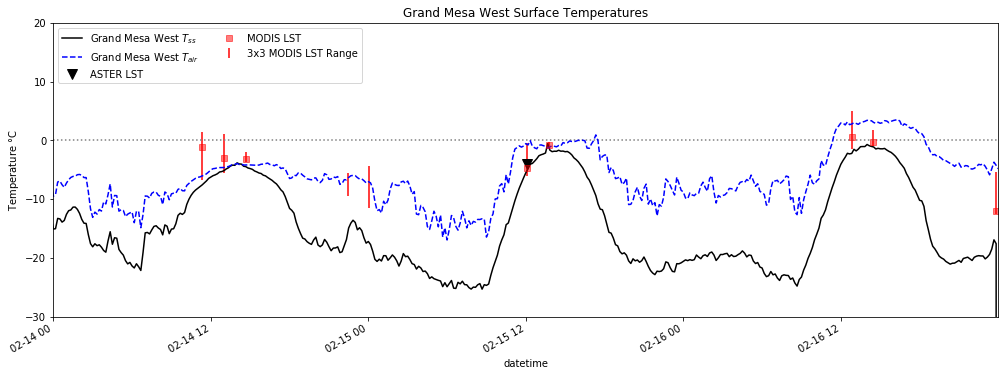

In [32]:
###
starttime = pd.to_datetime('2017-02-14 00:00')
endtime = pd.to_datetime('2017-02-16 23:59:59')

fig, ax = plt.subplots(figsize=(15,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gm_west.plot(x='datetime',y='IRtarget_nadir1_C_Avg (C, Avg)', color='k', ax=ax, label= 'Grand Mesa West $T_{ss}$')
gm_west.plot(x='datetime',y='AirTC_10ft_Avg (Deg C, Avg)', linestyle='--', color='b', ax=ax, label= 'Grand Mesa West $T_{air}$')

aster_time = pd.to_datetime('2017-02-15 12:07:26')
aster_LST = -4.07959
plt.plot(aster_time,aster_LST,'v',color='k',markersize=10,label='ASTER LST')

modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='r',linewidth=1.5,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))
plt.subplots_adjust(right=1)
plt.legend(loc='upper left',ncol=2) #bbox_to_anchor=(0.0, -0.05)
ax.set_xlim((starttime,endtime))
ax.set_ylim((-30,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Grand Mesa West Surface Temperatures');
plt.savefig('GMWest-MODIS-LST-timeline.png',dpi=300)

In [33]:
# Grand Mesa Middle surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\MW-V5t_spestana.csv'
gm_middle = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_middle['datetime'] = pd.to_datetime(gm_middle['TIMESTAMP (TS, )']) # timestamp string to pandas datetime
gm_middle['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_middle = gm_middle.sort_values('datetime').reset_index()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (32,36,37,38,39,41,45,46,47,48,95,96,97,98,138,139,140,141,224) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


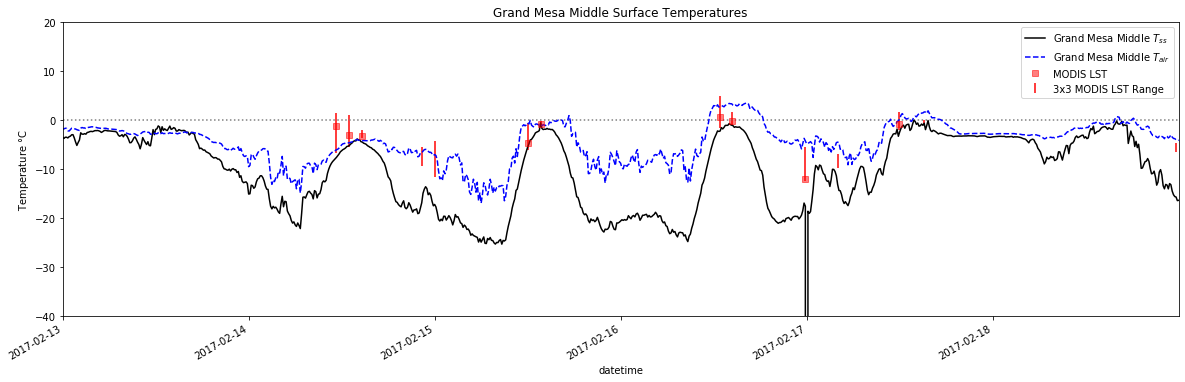

In [34]:
starttime = pd.to_datetime('2017-02-13 00:00')
endtime = pd.to_datetime('2017-02-18 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gm_middle.plot(x='datetime',y='IRtarget_nadir1_C_Avg (C, Avg)', color='k', ax=ax, label= 'Grand Mesa Middle $T_{ss}$')
gm_middle.plot(x='datetime',y='AirTC_10ft_Avg (Deg C, Avg)', linestyle='--', color='b', ax=ax, label= 'Grand Mesa Middle $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='r',linewidth=1.5,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))

plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Grand Mesa Middle Surface Temperatures');
plt.savefig('GMMiddle-MODIS-LST-timeline.png',dpi=300)

In [ ]:
# Grand Mesa LSOS surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\SnowEx\SnowEx Met Data\LSOS-V2t_spestana.csv'
gm_lsos = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_lsos['datetime'] = pd.to_datetime(gm_lsos['TIMESTAMP']) # timestamp string to pandas datetime
gm_lsos['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_lsos = gm_lsos.sort_values('datetime').reset_index()

In [ ]:
starttime = pd.to_datetime('2017-02-14 00:00')
endtime = pd.to_datetime('2017-02-16 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gm_lsos.plot(x='datetime',y='IRtarget_nadir1_C_Avg (C, Avg)', color='k', ax=ax, label= 'Grand Mesa LSOS $T_{ss}$')
gm_lsos.plot(x='datetime',y='AirTC_10ft_Avg (Deg C, Avg)', linestyle='--', color='b', ax=ax, label= 'Grand Mesa LSOS $T_{air}$')
aster_time = pd.to_datetime('2017-02-15 12:07:26')
aster_LST = -0.629333
plt.plot(aster_time,aster_LST,'v',color='k',markersize=10,label='ASTER LST')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.errorbar(modis.datetime,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='r',linewidth=1.5,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))

plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Grand Mesa LSOS Surface Temperatures');
plt.savefig('GMLSOS-MODIS-ASTER-LST-timeline.png',dpi=300)

Find the in situ observations closest in time to our MODIS data, compute the difference between MODIS LST and in situ Tsnow and Tair
Then plot MODIS LST vs in situ Tsnow and Tair to see how they compare...

(find the closest in time to our MODIS data, compute the difference between MODIS LST and Grand Mesa Tsnow and Tair)
Then plot MODIS LST vs Grand Mesa Tsnow and Tair to see how they compare...

In [35]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [36]:
# Compute the difference in temperatures (Grand Mesa - MODIS)
delta_tair = []
delta_tsnow = []
gm_tair = []
gm_tsnow = []

i = 0
for time in modis['datetime']:
    gm_time = (nearest(gm_west['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gm_tsnow.append(gm_west['IRtarget_nadir1_C_Avg (C, Avg)'][gm_west['datetime']==gm_time].values[0])
    gm_tair.append(gm_west['AirTC_10ft_Avg (Deg C, Avg)'][gm_west['datetime']==gm_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    modis_tmean = modis.temp_mean[modis['datetime']==time].values[0]
    modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gm_tsnow[i])
    delta_tair.append(modis_t - gm_tair[i])
    i+=1
    


KeyboardInterrupt: 

In [ ]:
# Compute the difference in temperatures (Grand Mesa - MODIS)
delta_tair = []
delta_tsnow = []
gm_tair = []
gm_tsnow = []

i = 0
for time in modis['datetime']:
    gm_time = (nearest(gm_west['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gm_tsnow.append(gm_west['IRtarget_nadir1_C_Avg (C, Avg)'][gm_west['datetime']==gm_time].values[0])
    gm_tair.append(gm_west['AirTC_10ft_Avg (Deg C, Avg)'][gm_west['datetime']==gm_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    modis_tmean = modis.temp_mean[modis['datetime']==time].values[0]
    modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gm_tsnow[i])
    delta_tair.append(modis_t - gm_tair[i])
    i+=1
    


In [ ]:
plt.figure(figsize=(6,6))
plt.plot(gm_tsnow,modis.temperature,'.k',label='Tsnow')
plt.plot(gm_tair,modis.temperature,'.b',label='Tair')

plt.errorbar(gm_tsnow,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='k',linewidth=1.5,alpha=0.4,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))
plt.errorbar(gm_tair,modis.temp_mean,
             yerr=np.array((modis.temp_max-modis.temp_min)/2),
             linestyle='None',c='b',linewidth=1.5,alpha=0.4,
             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))

plt.plot([-30,30],[-30,30],'--',c='tab:grey',label='1:1')
plt.plot([0,0],[-100,100],':',c='k',alpha=0.3)
plt.plot([-100,100],[0,0],':',c='k',alpha=0.3)
#plt.text(10,-30,'MODIS colder')
#plt.text(-30,19,'MODIS warmer')
plt.xlabel('Grand Mesa West Temperature, C')
plt.ylabel('MODIS LST, C')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.legend()
plt.savefig('GMwest-vs-MODIS-LST.png',dpi=300)


In [ ]:
# How does the difference between MODIS LST and ground data change as a function of time?

plt.figure(figsize=(15,5))
plt.plot(modis.datetime,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis.datetime,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Time')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Over Time\n(MODIS - Grand Mesa West)');

plt.savefig('GMwest-MODIS-deltaLST-timeline.png',dpi=300)

In [ ]:
# How does the difference between MODIS LST and ground data change as a function of hour of day?

plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Hour of Day')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([0, 24],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Hour of Day\n(MODIS - Gaylor Pit)');

plt.savefig('GMwest-MODIS-deltaLST-hour-of-day.png',dpi=300)

In [ ]:
# How does the difference between MODIS LST and ground data change as a function of view angle?

plt.plot(modis.viewangle,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

plt.savefig('GMwest-MODIS-deltaLST-view-angle.png',dpi=300)